<a href="https://colab.research.google.com/github/Kanedykane/litoX/blob/main/Litox_CNN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Morphometric and Morphological Sex Identification of *Tegillarca granosa (T. granosa)* Blood Cockles**

## Simple CNN Design

## **References**


*   code: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

*   website: https://www.analyticsvidhya.com/blog/2021/06/mnist-dataset-prediction-using-keras/



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Original from CNN resources

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras import layers

# eager execution
tf.compat.v1.enable_eager_execution()

# initialize seeds
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# path to the dataset
train_data_dir = "/content/drive/My Drive/SP 2024/Combined-Augmentation/Left Lateral/"

# model configuration
batch_size = 50
img_width, img_height, img_num_channels = 256, 256, 3
loss_function = binary_crossentropy
no_classes = 2
no_epochs = 20
verbosity = 1
num_folds = 5
metrics = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]


# per-fold score containers
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
all_predictions = []
all_true_labels = []
fold_history = []

# load the dataset using image_dataset_from_directory
dataset = image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=['Female', 'Male'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    interpolation='nearest',
    shuffle=True,
    seed=42,
    follow_links=False,
)


# dataset to list of images and labels
image_files = []
labels = []
for images, batch_labels in dataset.unbatch():
    image_files.append(images.numpy())
    labels.append(batch_labels.numpy())

image_files = np.array(image_files)
labels = np.array(labels)

# define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1

# eager execution enabled on GPU
with tf.device('/device:GPU:0'):
    for train, test in kfold.split(image_files, labels):
        # gather data for the current fold
        train_images = image_files[train]
        train_labels = labels[train]
        val_images = image_files[test]
        val_labels = labels[test]

        # create train and validation datasets
        train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)

        # CNN model
        model = Sequential([
            layers.Rescaling(1./255, input_shape=(256, 256, 3)),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((5, 5), padding='same'),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((5, 5), padding='same'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        # new optimizer for each fold
        optimizer = Adam(learning_rate=0.001)

        # compile the model with a new optimizer for each fold
        model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

        # training for the current fold
        print(f'------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        try:
            # fit the model to the current fold
            history = model.fit(train_ds, epochs=no_epochs, validation_data=val_ds, verbose=verbosity)
        except Exception as e:
            print(f"Error during training: {e}")
            continue

        # model evaluation
        scores = model.evaluate(val_ds, verbose=0)
        # print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
        print(f'Score for fold {fold_no}:')
        for metric, score in zip(model.metrics_names, scores):
            print(f'{metric}: {score}')


        # append the scores
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        all_predictions.append(scores[2])
        all_true_labels.append(scores[3])

        precision = scores[2]
        recall = scores[3]

        precision_per_fold.append(precision)
        recall_per_fold.append(recall)

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_per_fold.append(f1)


        # predictions on the validation set
        predictions = model.predict(val_ds)
        binary_predictions = (predictions > 0.5).astype(int)



        # increment fold number
        fold_no += 1

# average scores
print('------------------------------------------------------------------------')
print('Score per fold:')
for i in range(len(acc_per_fold)):
    print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Precision: {np.mean(precision_per_fold)}')
print(f'> Recall: {np.mean(recall_per_fold)}')
print(f'> F1 score: {np.mean(f1_per_fold)}')
print('------------------------------------------------------------------------')

model.summary()

**Separated into Functions**

*   seed and environment
*   load dataset
*   cnn model
*   train model
*   evaluate model [metrics]
*   train and evaluate kfolds
*   display result
*   visualizations











## version 2 - Run this


Group K-Fold is a method of cross-validation used in machine learning to ensure that the data from different groups (such as different participants) are not mixed between the training and testing sets. This is particularly important when the data points are not independent and come from a few groups

# Adjusted the group kfold

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
import re

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from sklearn.utils import class_weight
# from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold


tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()
# train_data_dir = "/content/drive/My Drive/FOURTH YEAR/SP/SP 2024/Angles/Colored/Left_Lateral_Colored/"
train_data_dir = "/content/drive/My Drive/SP 2024/Combined Augmentation/Left Lateral/"

def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=False,
        seed=42,
    )

    images = []
    labels = []
    base_ids = []

    file_paths = dataset.file_paths if hasattr(dataset, 'file_paths') else []

    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())

    for path in file_paths:
      filename = os.path.basename(path)
      base_id = re.match(r'(\d+)', filename.split('_')[0]).group(1)
      base_ids.append(base_id)

    return np.concatenate(images), np.concatenate(labels).astype(np.float32), np.array(base_ids)

def cnn_model(img_width=256, img_height=256):
    model = Sequential([
        layers.Input(shape=(img_width, img_height, 3)),
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'), # strides=2
        layers.MaxPooling2D((3, 3), padding='same'),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'), # strides=2
        layers.MaxPooling2D((3, 3), padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_evaluate_fold(
    train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256,
    no_epochs=50,
    num_folds=5
):
    seed_and_environment()
    image_files, labels, base_ids = load_dataset(train_data_dir, batch_size, img_width, img_height)
    Group_kfold = GroupKFold(n_splits=num_folds)

    all_predictions = []
    all_true_labels = []
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    auc_per_fold = []
    fold_history = []
    fold_metrics = {
        'fold_no': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auc': []
    }

    for fold_no, (train_idx, test_idx) in enumerate(Group_kfold.split(image_files, labels, groups=base_ids), 1):
        print(f'\n{"-"*80}')
        print(f'Training fold {fold_no}')

        # test data leakage
        train_base_id = set(base_ids[train_idx])
        test_base_id = set(base_ids[test_idx])
        overlap = train_base_id.intersection(test_base_id)
        assert len(overlap) == 0, f"Data leakage detected in fold {fold_no}: {overlap}"

        print(f"Train Base IDs: {train_base_id}")
        print(f"Test Base IDs: {test_base_id}")

        # create datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[train_idx], labels[train_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[test_idx], labels[test_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # create and compile model
        model = cnn_model(img_width, img_height)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=binary_crossentropy,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels[train_idx]), y=labels[train_idx])
        class_weights = dict(enumerate(class_weights))

        # train
        history = model.fit(
            train_ds,
            epochs=no_epochs,
            validation_data=val_ds,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)],
            class_weight=class_weights
        )
        fold_history.append(history)

        # evaluate
        scores = model.evaluate(val_ds, verbose=0)
        print(f'\nFold {fold_no} Scores:')
        for name, score in zip(model.metrics_names, scores):
            print(f"{name}: {score:.2f}")

        y_pred = model.predict(val_ds)
        y_true = labels[test_idx]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        precision = scores[2]
        recall = scores[3]
        f1 = (2 * (scores[2] * scores[3]) / (scores[2] + scores[3] + 1e-7))

        # store metrics (multiply scores by 100)
        fold_metrics['fold_no'].append(fold_no)
        fold_metrics['loss'].append(scores[0])
        fold_metrics['accuracy'].append(scores[1] * 100)
        fold_metrics['precision'].append(precision * 100)
        fold_metrics['recall'].append(recall * 100)
        fold_metrics['f1_score'].append(f1 * 100)
        fold_metrics['auc'].append(roc_auc * 100)

        # append scores
        all_predictions.append(y_pred)
        all_true_labels.append(y_true)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        auc_per_fold.append(roc_auc * 100)
        precision_per_fold.append(precision * 100)
        recall_per_fold.append(recall * 100)
        f1_per_fold.append(f1 * 100)

    # display results
    print('\n' + '-'*80)
    print('Score per fold:')
    for i in range(len(acc_per_fold)):
        print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print(f'> Fold {i + 1} - Precision: {precision_per_fold[i]}%')
        print(f'> Fold {i + 1} - Recall: {recall_per_fold[i]}%')
        print(f'> Fold {i + 1} - F1 score: {f1_per_fold[i]}%')
        print(f'> Fold {i + 1} - AUC: {auc_per_fold[i]}%')

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold):.2f}% (±{np.std(acc_per_fold):.2f})')
    print(f'Loss: {np.mean(loss_per_fold):.2f} (±{np.std(loss_per_fold):.2f})')
    print(f'Precision: {np.mean(precision_per_fold):.2f}% (±{np.std(precision_per_fold):.2f})')
    print(f'Recall: {np.mean(recall_per_fold):.2f}% (±{np.std(recall_per_fold):.2f})')
    print(f'F1: {np.mean(f1_per_fold):.2f}% (±{np.std(f1_per_fold):.2f})')
    print('-'*80 + '\n')

    return model, fold_history, all_predictions, all_true_labels

# run training
model, fold_history, all_predictions, all_true_labels = train_evaluate_fold(train_data_dir)

# save the model
# model.save('gender_classifier_model.keras')

# model summary
model.summary()

Found 815 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



--------------------------------------------------------------------------------
Training fold 1
Train Base IDs: {np.str_('150053'), np.str_('050103'), np.str_('050222'), np.str_('150181'), np.str_('150154'), np.str_('150052'), np.str_('150252'), np.str_('050245'), np.str_('050106'), np.str_('150197'), np.str_('150016'), np.str_('150062'), np.str_('150023'), np.str_('050220'), np.str_('050244'), np.str_('050109'), np.str_('150028'), np.str_('150145'), np.str_('050269'), np.str_('050133'), np.str_('150184'), np.str_('150247'), np.str_('050211'), np.str_('150172'), np.str_('050083'), np.str_('150249'), np.str_('050270'), np.str_('150027'), np.str_('050204'), np.str_('150063'), np.str_('050263'), np.str_('050134'), np.str_('150005'), np.str_('050209'), np.str_('050246'), np.str_('150006'), np.str_('150193'), np.str_('150158'), np.str_('050091'), np.str_('050205'), np.str_('050081'), np.str_('150182'), np.str_('150035'), np.str_('150019'), np.str_('050229'), np.str_('050242'), np.str_('15

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - accuracy: 0.7940 - auc: 0.3241 - loss: 4.8956 - precision: 0.3059 - recall: 0.0986 - val_accuracy: 0.5951 - val_auc: 0.4330 - val_loss: 1.1340 - val_precision: 0.5951 - val_recall: 1.0000
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 446ms/step - accuracy: 0.1016 - auc: 0.0433 - loss: 1.6292 - precision: 0.0597 - recall: 0.0858 - val_accuracy: 0.4049 - val_auc: 0.5623 - val_loss: 0.6980 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 444ms/step - accuracy: 0.4783 - auc: 0.2516 - loss: 0.6890 - precision: 0.1024 - recall: 0.0792 - val_accuracy: 0.5951 - val_auc: 0.4576 - val_loss: 0.6923 - val_precision: 0.5951 - val_recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.2289 - auc: 0.2409 - loss: 0.6960 - precision: 0.2289 - recall: 0.6000 - val_accuracy: 0.5951 - val_auc: 0.5000 - val_loss: 0.6921 - val_precision: 0.5951 - val_recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.7145 - auc: 0.3126 - loss: 5.4249 - precision: 0.2104 - recall: 0.0563 - val_accuracy: 0.5399 - val_auc: 0.4901 - val_loss: 0.7054 - val_precision: 0.5399 - val_recall: 1.0000
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.3063 - auc: 0.1049 - loss: 0.8904 - precision: 0.0649 - recall: 0.0361 - val_accuracy: 0.5399 - val_auc: 0.4800 - val_loss: 0.6929 - val_precision: 0.5399 - val_recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - accuracy: 0.2395 - auc: 0.2541 - loss: 0.6955 - precision: 0.2395 - recall: 0.6000 - val_accuracy: 0.5399 - val_auc: 0.5000 - val_loss: 0.6927 - val_precision: 0.5399 - val_recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - accuracy: 0.2395 - auc: 0.2960 - loss: 0.6967 - precision: 0.2395 - recall: 0.6000 - val_accuracy: 0.5399 - val_auc: 0.5000 - val_loss: 0.6926 - val_precision: 0.5399 - val_recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 44

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 485ms/step - accuracy: 0.6942 - auc: 0.2900 - loss: 4.3432 - precision: 0.1635 - recall: 0.0532 - val_accuracy: 0.5273 - val_auc: 0.3854 - val_loss: 0.8254 - val_precision: 0.5273 - val_recall: 1.0000
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.2246 - auc: 0.0710 - loss: 1.0289 - precision: 0.0432 - recall: 0.0287 - val_accuracy: 0.5273 - val_auc: 0.4618 - val_loss: 0.6920 - val_precision: 0.5273 - val_recall: 1.0000
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.1560 - auc: 0.0537 - loss: 0.7247 - precision: 0.1090 - recall: 0.1342 - val_accuracy: 0.5273 - val_auc: 0.5000 - val_loss: 0.6930 - val_precision: 0.5273 - val_recall: 1.0000
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.1863 - auc: 0.2510 - loss: 0.6954 - precision: 0.1989 - recall: 0.4713 - val_accuracy: 0.5273 - val_auc: 0.5000 - val_loss: 0.6929 - val_precision: 0.5273 - val_recall: 1.0000
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 47

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.6548 - auc: 0.3177 - loss: 5.7964 - precision: 0.2215 - recall: 0.0852 - val_accuracy: 0.5185 - val_auc: 0.3313 - val_loss: 1.0642 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step - accuracy: 0.1371 - auc: 0.0440 - loss: 1.3772 - precision: 0.1451 - recall: 0.2515 - val_accuracy: 0.5247 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.5340 - val_recall: 0.6548
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.4469 - auc: 0.1076 - loss: 0.7119 - precision: 0.0761 - recall: 0.0368 - val_accuracy: 0.4815 - val_auc: 0.5192 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - accuracy: 0.5092 - auc: 0.3332 - loss: 0.6933 - precision: 0.2734 - recall: 0.4210 - val_accuracy: 0.5185 - val_auc: 0.4849 - val_loss: 0.6927 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - accuracy: 0.7254 - auc: 0.3558 - loss: 5.7094 - precision: 0.2823 - recall: 0.1149 - val_accuracy: 0.4815 - val_auc: 0.4268 - val_loss: 2.4861 - val_precision: 0.4815 - val_recall: 1.0000
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.1507 - auc: 0.0585 - loss: 2.3303 - precision: 0.0403 - recall: 0.0299 - val_accuracy: 0.4815 - val_auc: 0.5395 - val_loss: 0.7005 - val_precision: 0.4815 - val_recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 444ms/step - accuracy: 0.3668 - auc: 0.1238 - loss: 0.7713 - precision: 0.1261 - recall: 0.0831 - val_accuracy: 0.4815 - val_auc: 0.5000 - val_loss: 0.6934 - val_precision: 0.4815 - val_recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.2509 - auc: 0.1642 - loss: 0.6961 - precision: 0.2509 - recall: 0.6667 - val_accuracy: 0.4815 - val_auc: 0.5000 - val_loss: 0.6934 - val_precision: 0.4815 - val_recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 44

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 86, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 86, 86, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 26912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,395,749 (39.66 MB)

 Trainable params: 3,465,249 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,930,500 (26.44 MB)

## Architecture adjusted

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
import re

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from sklearn.utils import class_weight
# from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold


tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()
# train_data_dir = "/content/drive/My Drive/FOURTH YEAR/SP/SP 2024/Angles/Colored/Left_Lateral_Colored/"
train_data_dir = "/content/drive/My Drive/SP 2024/Combined Augmentation/Left Lateral/"

def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=False,
        seed=42,
    )

    images = []
    labels = []
    base_ids = []

    file_paths = dataset.file_paths if hasattr(dataset, 'file_paths') else []

    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())

    for path in file_paths:
      filename = os.path.basename(path)
      base_id = re.match(r'(\d+)', filename.split('_')[0]).group(1)
      base_ids.append(base_id)

    return np.concatenate(images), np.concatenate(labels).astype(np.float32), np.array(base_ids)

def cnn_model(img_width=256, img_height=256):
    model = Sequential([
        layers.Input(shape=(img_width, img_height, 3)),

        # Normalize input
        layers.Rescaling(1./255),

        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Conv Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Fully connected head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


def train_evaluate_fold(
    train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256,
    no_epochs=50,
    num_folds=5
):
    seed_and_environment()
    image_files, labels, base_ids = load_dataset(train_data_dir, batch_size, img_width, img_height)
    Group_kfold = GroupKFold(n_splits=num_folds)

    all_predictions = []
    all_true_labels = []
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    auc_per_fold = []
    fold_history = []
    fold_metrics = {
        'fold_no': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auc': []
    }

    for fold_no, (train_idx, test_idx) in enumerate(Group_kfold.split(image_files, labels, groups=base_ids), 1):
        print(f'\n{"-"*80}')
        print(f'Training fold {fold_no}')

        # test data leakage
        train_base_id = set(base_ids[train_idx])
        test_base_id = set(base_ids[test_idx])
        overlap = train_base_id.intersection(test_base_id)
        assert len(overlap) == 0, f"Data leakage detected in fold {fold_no}: {overlap}"

        print(f"Train Base IDs: {train_base_id}")
        print(f"Test Base IDs: {test_base_id}")

        # create datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[train_idx], labels[train_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[test_idx], labels[test_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # create and compile model
        model = cnn_model(img_width, img_height)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=binary_crossentropy,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels[train_idx]), y=labels[train_idx])
        class_weights = dict(enumerate(class_weights))

        # train
        history = model.fit(
            train_ds,
            epochs=no_epochs,
            validation_data=val_ds,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)],
            class_weight=class_weights
        )
        fold_history.append(history)

        # evaluate
        scores = model.evaluate(val_ds, verbose=0)
        print(f'\nFold {fold_no} Scores:')
        for name, score in zip(model.metrics_names, scores):
            print(f"{name}: {score:.2f}")

        y_pred = model.predict(val_ds)
        y_true = labels[test_idx]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        precision = scores[2]
        recall = scores[3]
        f1 = (2 * (scores[2] * scores[3]) / (scores[2] + scores[3] + 1e-7))

        # store metrics (multiply scores by 100)
        fold_metrics['fold_no'].append(fold_no)
        fold_metrics['loss'].append(scores[0])
        fold_metrics['accuracy'].append(scores[1] * 100)
        fold_metrics['precision'].append(precision * 100)
        fold_metrics['recall'].append(recall * 100)
        fold_metrics['f1_score'].append(f1 * 100)
        fold_metrics['auc'].append(roc_auc * 100)

        # append scores
        all_predictions.append(y_pred)
        all_true_labels.append(y_true)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        auc_per_fold.append(roc_auc * 100)
        precision_per_fold.append(precision * 100)
        recall_per_fold.append(recall * 100)
        f1_per_fold.append(f1 * 100)

    # display results
    print('\n' + '-'*80)
    print('Score per fold:')
    for i in range(len(acc_per_fold)):
        print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print(f'> Fold {i + 1} - Precision: {precision_per_fold[i]}%')
        print(f'> Fold {i + 1} - Recall: {recall_per_fold[i]}%')
        print(f'> Fold {i + 1} - F1 score: {f1_per_fold[i]}%')
        print(f'> Fold {i + 1} - AUC: {auc_per_fold[i]}%')

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold):.2f}% (±{np.std(acc_per_fold):.2f})')
    print(f'Loss: {np.mean(loss_per_fold):.2f} (±{np.std(loss_per_fold):.2f})')
    print(f'Precision: {np.mean(precision_per_fold):.2f}% (±{np.std(precision_per_fold):.2f})')
    print(f'Recall: {np.mean(recall_per_fold):.2f}% (±{np.std(recall_per_fold):.2f})')
    print(f'F1: {np.mean(f1_per_fold):.2f}% (±{np.std(f1_per_fold):.2f})')
    print('-'*80 + '\n')

    return model, fold_history, all_predictions, all_true_labels

# run training
model, fold_history, all_predictions, all_true_labels = train_evaluate_fold(train_data_dir)

# save the model
# model.save('gender_classifier_model.keras')

# model summary
model.summary()

Found 815 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



--------------------------------------------------------------------------------
Training fold 1
Train Base IDs: {np.str_('150053'), np.str_('050103'), np.str_('050222'), np.str_('150181'), np.str_('150154'), np.str_('150052'), np.str_('150252'), np.str_('050245'), np.str_('050106'), np.str_('150197'), np.str_('150016'), np.str_('150062'), np.str_('150023'), np.str_('050220'), np.str_('050244'), np.str_('050109'), np.str_('150028'), np.str_('150145'), np.str_('050269'), np.str_('050133'), np.str_('150184'), np.str_('150247'), np.str_('050211'), np.str_('150172'), np.str_('050083'), np.str_('150249'), np.str_('050270'), np.str_('150027'), np.str_('050204'), np.str_('150063'), np.str_('050263'), np.str_('050134'), np.str_('150005'), np.str_('050209'), np.str_('050246'), np.str_('150006'), np.str_('150193'), np.str_('150158'), np.str_('050091'), np.str_('050205'), np.str_('050081'), np.str_('150182'), np.str_('150035'), np.str_('150019'), np.str_('050229'), np.str_('050242'), np.str_('15

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 532ms/step - accuracy: 0.8028 - auc: 0.3760 - loss: 72.7520 - precision: 0.3672 - recall: 0.1562 - val_accuracy: 0.4908 - val_auc: 0.3511 - val_loss: 0.7126 - val_precision: 0.5574 - val_recall: 0.7010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step - accuracy: 0.1991 - auc: 0.0782 - loss: 42.3028 - precision: 0.0083 - recall: 0.0050 - val_accuracy: 0.5951 - val_auc: 0.5184 - val_loss: 0.8491 - val_precision: 0.5951 - val_recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - accuracy: 0.4863 - auc: 0.3555 - loss: 0.6748 - precision: 0.2583 - recall: 0.6000 - val_accuracy: 0.5951 - val_auc: 0.5229 - val_loss: 0.8749 - val_precision: 0.5951 - val_recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 510ms/step - accuracy: 0.2289 - auc: 0.3006 - loss: 0.7080 - precision: 0.2289 - recall: 0.6000 - val_accuracy: 0.5951 - val_auc: 0.5279 - val_loss: 0.8252 - val_precision: 0.5951 - val_recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 530ms/step - accuracy: 0.7706 - auc: 0.3949 - loss: 74.1995 - precision: 0.3575 - recall: 0.1625 - val_accuracy: 0.5399 - val_auc: 0.4389 - val_loss: 0.7918 - val_precision: 0.5399 - val_recall: 1.0000
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 518ms/step - accuracy: 0.1996 - auc: 0.0790 - loss: 32.3752 - precision: 0.0116 - recall: 0.0067 - val_accuracy: 0.5399 - val_auc: 0.5689 - val_loss: 0.6884 - val_precision: 0.5399 - val_recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step - accuracy: 0.3951 - auc: 0.3338 - loss: 0.7103 - precision: 0.2558 - recall: 0.6000 - val_accuracy: 0.5399 - val_auc: 0.5642 - val_loss: 0.6893 - val_precision: 0.5399 - val_recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - accuracy: 0.2395 - auc: 0.3000 - loss: 0.7195 - precision: 0.2395 - recall: 0.6000 - val_accuracy: 0.5399 - val_auc: 0.5883 - val_loss: 0.6906 - val_precision: 0.5399 - val_recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 560ms/step - accuracy: 0.7159 - auc: 0.3315 - loss: 93.5584 - precision: 0.2206 - recall: 0.0783 - val_accuracy: 0.4727 - val_auc: 0.4646 - val_loss: 1.5930 - val_precision: 0.5000 - val_recall: 0.4253
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 541ms/step - accuracy: 0.2719 - auc: 0.0891 - loss: 11.1370 - precision: 0.0460 - recall: 0.0310 - val_accuracy: 0.5273 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.5273 - val_recall: 1.0000
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 541ms/step - accuracy: 0.2360 - auc: 0.2867 - loss: 0.7232 - precision: 0.2233 - recall: 0.5714 - val_accuracy: 0.5273 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.5273 - val_recall: 1.0000
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 539ms/step - accuracy: 0.2221 - auc: 0.2857 - loss: 0.7236 - precision: 0.2221 - recall: 0.5714 - val_accuracy: 0.5273 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.5273 - val_recall: 1.0000
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 532ms/step - accuracy: 0.7861 - auc: 0.4167 - loss: 73.6154 - precision: 0.3971 - recall: 0.2809 - val_accuracy: 0.5185 - val_auc: 0.5337 - val_loss: 1.7040 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - accuracy: 0.1699 - auc: 0.0844 - loss: 94.7324 - precision: 0.0020 - recall: 0.0011 - val_accuracy: 0.4753 - val_auc: 0.4954 - val_loss: 0.7011 - val_precision: 0.4950 - val_recall: 0.5952
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 513ms/step - accuracy: 0.8206 - auc: 0.3616 - loss: 0.6908 - precision: 0.3333 - recall: 0.1230 - val_accuracy: 0.5185 - val_auc: 0.4808 - val_loss: 0.6947 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step - accuracy: 0.2432 - auc: 0.3006 - loss: 0.7228 - precision: 0.2432 - recall: 0.6000 - val_accuracy: 0.5185 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 528ms/step - accuracy: 0.7671 - auc: 0.4356 - loss: 59.6458 - precision: 0.3860 - recall: 0.2402 - val_accuracy: 0.4815 - val_auc: 0.4783 - val_loss: 3.1278 - val_precision: 0.4815 - val_recall: 1.0000
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.1719 - auc: 0.1004 - loss: 63.9702 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5185 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.7491 - auc: 0.3838 - loss: 0.7117 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4815 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.4815 - val_recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.1269 - auc: 0.3333 - loss: 0.7305 - precision: 0.1626 - recall: 0.3844 - val_accuracy: 0.4815 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.4815 - val_recall: 1.0000
Epoch 5/50
14/14 

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_23 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,502,277 (196.47 MB)

 Trainable params: 17,167,105 (65.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 34,334,212 (130.97 MB)

In [ ]:
import tensorflow as tf
import numpy as np
import os
import re
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import GroupKFold
from sklearn.utils import class_weight
import gc

# 1. Configure GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# 2. Fixed Data Loading Function
def safe_load_dataset(train_data_dir, batch_size, img_size):
    """Load data with proper index handling"""
    # Load to CPU first
    with tf.device('/CPU:0'):
        dataset = image_dataset_from_directory(
            train_data_dir,
            labels='inferred',
            label_mode='int',
            class_names=['Female', 'Male'],
            color_mode='rgb',
            batch_size=batch_size,
            image_size=img_size,
            shuffle=False,
            seed=42
        )

        # Get file paths and base IDs
        file_paths = dataset.file_paths
        base_ids = [re.match(r'(\d+)', os.path.basename(p).split('_')[0]).group(1) for p in file_paths]
        base_ids = np.array(base_ids)

        # Load images and labels
        images, labels = [], []
        for img, lbl in dataset:
            images.append(img.numpy())
            labels.append(lbl.numpy())

        images = np.concatenate(images).astype('float32')
        labels = np.concatenate(labels).astype('float32')

        # Class balancing
        female_idx = np.where(labels == 0)[0]
        male_idx = np.where(labels == 1)[0]
        male_idx = np.random.choice(male_idx, size=len(female_idx), replace=False)
        balanced_idx = np.concatenate([female_idx, male_idx])

        return (
            tf.convert_to_tensor(images[balanced_idx]),
            tf.convert_to_tensor(labels[balanced_idx]),
            base_ids[balanced_idx]
        )

# 3. Fixed Model Creation
def create_safe_model(img_size=(256, 256)):
    """Simpler model to reduce memory issues"""
    model = models.Sequential([
        layers.Input(shape=(*img_size, 3), dtype=tf.float32),
        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC']
    )
    return model

# 4. Fixed Training Loop
def safe_training(train_data_dir, batch_size=8, img_size=(256, 256), num_folds=5):
    """Training with proper index handling"""
    # Load data
    images, labels, base_ids = safe_load_dataset(train_data_dir, batch_size, img_size)

    # Convert to numpy arrays for GroupKFold
    images_np = images.numpy() if tf.is_tensor(images) else images
    labels_np = labels.numpy() if tf.is_tensor(labels) else labels
    base_ids_np = base_ids.numpy() if tf.is_tensor(base_ids) else base_ids

    gkf = GroupKFold(n_splits=num_folds)
    results = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(images_np, labels_np, groups=base_ids_np), 1):
        print(f"\nFold {fold}/{num_folds}")

        # Clear previous models
        tf.keras.backend.clear_session()
        gc.collect()

        # Create datasets with proper indices
        train_ds = tf.data.Dataset.from_tensor_slices(
            (tf.gather(images, train_idx),
             tf.gather(labels, train_idx))
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (tf.gather(images, val_idx),
             tf.gather(labels, val_idx))
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Class weights
        class_weights = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(labels_np[train_idx]),
            y=labels_np[train_idx]
        )
        class_weights = dict(enumerate(class_weights))

        # Create and train model
        model = create_safe_model(img_size)

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=30,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
            ],
            class_weight=class_weights,
            verbose=1
        )

        # Evaluate
        val_results = model.evaluate(val_ds, verbose=0)
        results.append({
            'fold': fold,
            'metrics': dict(zip(model.metrics_names, val_results))
        })

    return results

# 5. Run with error handling
try:
    results = safe_training(
        train_data_dir="/content/drive/My Drive/SP 2024/Combined Augmentation/Left Lateral/",
        batch_size=8,
        img_size=(256, 256),
        num_folds=5
    )

    # Print results
    print("\nTraining Results:")
    for res in results:
        print(f"\nFold {res['fold']}:")
        for name, value in res['metrics'].items():
            print(f"{name}: {value:.4f}")

    # 6. Display average results
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []

    for res in results:
        metrics = res['metrics']
        acc_per_fold.append(metrics['accuracy'])
        loss_per_fold.append(metrics['loss'])
        precision_per_fold.append(metrics['precision'])
        recall_per_fold.append(metrics['recall'])

        # Compute F1 score
        prec = metrics['precision']
        rec = metrics['recall']
        f1 = 2 * (prec * rec) / (prec + rec + 1e-7)  # avoid division by zero
        f1_per_fold.append(f1)

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold) * 100:.2f}% (±{np.std(acc_per_fold) * 100:.2f})')
    print(f'Loss: {np.mean(loss_per_fold):.4f} (±{np.std(loss_per_fold):.4f})')
    print(f'Precision: {np.mean(precision_per_fold):.4f} (±{np.std(precision_per_fold):.4f})')
    print(f'Recall: {np.mean(recall_per_fold):.4f} (±{np.std(recall_per_fold):.4f})')
    print(f'F1: {np.mean(f1_per_fold):.4f} (±{np.std(f1_per_fold):.4f})')
    print('-'*80 + '\n')

except Exception as e:
    print(f"Error: {str(e)}")
    print("Trying CPU-only mode...")

    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    results = safe_training(
        train_data_dir="/content/drive/My Drive/SP 2024/Combined Augmentation/Left Lateral/",
        batch_size=8,
        img_size=(256, 256),
        num_folds=5
    )


Physical devices cannot be modified after being initialized
Found 815 files belonging to 2 classes.

Fold 1/5
Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - AUC: 0.4157 - Precision: 0.4296 - Recall: 0.2934 - accuracy: 0.9408 - loss: 1.5001 - val_AUC: 0.5000 - val_Precision: 0.4902 - val_Recall: 1.0000 - val_accuracy: 0.4902 - val_loss: 9.1863
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - AUC: 0.1799 - Precision: 0.1324 - Recall: 0.1357 - accuracy: 0.3600 - loss: 6.0454 - val_AUC: 0.3788 - val_Precision: 0.4902 - val_Recall: 1.0000 - val_accuracy: 0.4902 - val_loss: 1.6012
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - AUC: 0.0902 - Precision: 0.0425 - Recall: 0.0313 - accuracy: 0.2860 - loss: 1.5255 - val_AUC: 0.5913 - val_Precision: 0.4902 - val_Recall: 1.0000 - val_accuracy: 0.4902 - val_loss: 0.6949
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - AUC: 0.1430 - Precision: 0.1306 - Recall: 0.0909 - accuracy: 0.5418 - loss: 0.8172 - val_AUC: 0.4986 - val

# The original (not augmented)

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from sklearn.model_selection import KFold

tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()
# train_data_dir = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/"
train_data_dir = "/content/drive/My Drive/SP 2024/Combined-Augmentation/Left Lateral/"

def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=True,
        seed=42,
        )

    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels).astype(np.float32)

def cnn_model(img_width=256, img_height=256):
    model = Sequential([
        layers.Input(shape=(img_width, img_height,3)),
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((5, 5), padding='same'),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((5, 5), padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_evaluate_fold(
    train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256,
    no_epochs=30,
    num_folds=5
):
    seed_and_environment()
    image_files, labels = load_dataset(train_data_dir, batch_size, img_width, img_height)
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    all_predictions = []
    all_true_labels = []
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    auc_per_fold = []
    fold_history = []
    fold_metrics = {
        'fold_no': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auc':[]
    }

    for fold_no, (train_idx, test_idx) in enumerate(kfold.split(image_files, labels), 1):
        print(f'\n{"-"*80}')
        print(f'Training fold {fold_no}')

        # Create datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[train_idx], labels[train_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[test_idx], labels[test_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create and compile model
        model = cnn_model(img_width, img_height)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=binary_crossentropy,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        # Train
        history = model.fit(
            train_ds,
            epochs=no_epochs,
            validation_data=val_ds,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

        )
        fold_history.append(history)

        # Evaluate
        scores = model.evaluate(val_ds, verbose=0)
        print(f'\nFold {fold_no} Scores:')
        for name, score in zip(model.metrics_names, scores):
            print(f"{name}: {score:.4f}")

        y_pred = model.predict(val_ds)
        y_true = labels[test_idx]
        fpr, tpr,_ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        precision = scores[2]
        recall = scores[3]
        f1 = (2 * (scores[2] * scores[3]) / (scores[2] + scores[3] + 1e-7))


        # Store metrics
        fold_metrics['fold_no'].append(fold_no)
        fold_metrics['loss'].append(scores[0])
        fold_metrics['accuracy'].append(scores[1] * 100)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1_score'].append(f1)
        fold_metrics['auc'].append(roc_auc)

        # Append scores
        all_predictions.append(y_pred)
        all_true_labels.append(y_true)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        auc_per_fold.append(roc_auc)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)


    # Display results
    print('\n' + '-'*80)
    print('Score per fold:')
    for i in range(len(acc_per_fold)):
      print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
      print(f'> Fold {i + 1} - Precision: {precision_per_fold[i]}%')
      print(f'> Fold {i + 1} - Recall: {recall_per_fold[i]}%')
      print(f'> Fold {i + 1} - F1 score: {f1_per_fold[i]}%')
      print(f'> Fold {i + 1} - AUC: {auc_per_fold[i]}%')

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold):.2f}% (±{np.std(acc_per_fold):.2f})')
    print(f'Loss: {np.mean(loss_per_fold):.4f} (±{np.std(loss_per_fold):.4f})')
    print(f'Precision: {np.mean(precision_per_fold):.4f} (±{np.std(precision_per_fold):.4f})')
    print(f'Recall: {np.mean(recall_per_fold):.4f} (±{np.std(recall_per_fold):.4f})')
    print(f'F1: {np.mean(f1_per_fold):.4f} (±{np.std(f1_per_fold):.4f})')
    print('-'*80 + '\n')

    return model, fold_history, all_predictions, all_true_labels

# Run training
model, fold_history, all_predictions, all_true_labels = train_evaluate_fold(train_data_dir)

# Save the model
# trained_model.save('gender_classifier_model')

# model summary
model.summary()

Found 273 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



--------------------------------------------------------------------------------
Training fold 1
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.4967 - auc: 0.4826 - loss: 0.7230 - precision: 0.5243 - recall: 0.5771 - val_accuracy: 0.4909 - val_auc: 0.5767 - val_loss: 0.7051 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - accuracy: 0.4587 - auc: 0.4428 - loss: 0.7269 - precision: 0.4963 - recall: 0.0312 - val_accuracy: 0.4909 - val_auc: 0.4828 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.5243 - auc: 0.5666 - loss: 0.6920 - precision: 0.5918 - recall: 0.3968 - val_accuracy: 0.5091 - val_auc: 0.5000 - val_loss: 0.6928 - val_precision: 0.5091 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.5717 - auc: 0.4353 - loss: 0.6928 - precision: 0.5606 - recall: 0.9431 - val_accuracy: 0.5091 - val_auc: 0.6144 - val_loss: 0.6928 - val_precision: 0.5091 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - accuracy: 0.4883 - auc: 0.4775 - loss: 0.7395 - precision: 0.5007 - recall: 0.4790 - val_accuracy: 0.5636 - val_auc: 0.6828 - val_loss: 0.6840 - val_precision: 0.5636 - val_recall: 1.0000
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.4800 - auc: 0.4719 - loss: 0.7064 - precision: 0.4975 - recall: 0.4720 - val_accuracy: 0.4364 - val_auc: 0.6774 - val_loss: 0.6954 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.5507 - auc: 0.5385 - loss: 0.6927 - precision: 0.6958 - recall: 0.2970 - val_accuracy: 0.5636 - val_auc: 0.6633 - val_loss: 0.6901 - val_precision: 0.5636 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.5113 - auc: 0.5643 - loss: 0.6891 - precision: 0.5204 - recall: 0.6627 - val_accuracy: 0.5636 - val_auc: 0.6532 - val_loss: 0.6855 - val_precision: 0.5636 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step - accuracy: 0.4917 - auc: 0.4717 - loss: 0.7839 - precision: 0.4608 - recall: 0.3328 - val_accuracy: 0.6000 - val_auc: 0.4105 - val_loss: 0.6786 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - accuracy: 0.4951 - auc: 0.4474 - loss: 0.7052 - precision: 0.4938 - recall: 0.9468 - val_accuracy: 0.6000 - val_auc: 0.5000 - val_loss: 0.6914 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - accuracy: 0.4821 - auc: 0.5097 - loss: 0.6934 - precision: 0.4859 - recall: 0.7093 - val_accuracy: 0.5818 - val_auc: 0.4470 - val_loss: 0.6930 - val_precision: 0.6136 - val_recall: 0.8182
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.4839 - auc: 0.5258 - loss: 0.6926 - precision: 0.4781 - recall: 0.4510 - val_accuracy: 0.4364 - val_auc: 0.4793 - val_loss: 0.6933 - val_precision: 0.5455 - val_recall: 0.3636
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 0.4140 - auc: 0.4321 - loss: 0.8704 - precision: 0.4168 - recall: 0.3364 - val_accuracy: 0.5185 - val_auc: 0.3984 - val_loss: 0.6936 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.5011 - auc: 0.5042 - loss: 0.6921 - precision: 0.5086 - recall: 0.7061 - val_accuracy: 0.5185 - val_auc: 0.5213 - val_loss: 0.6922 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.5025 - auc: 0.4629 - loss: 0.6952 - precision: 0.5114 - recall: 0.8349 - val_accuracy: 0.5185 - val_auc: 0.5735 - val_loss: 0.6916 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.5185 - auc: 0.5670 - loss: 0.6913 - precision: 0.5175 - recall: 0.9460 - val_accuracy: 0.5185 - val_auc: 0.6429 - val_loss: 0.6912 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.4857 - auc: 0.4966 - loss: 0.8301 - precision: 0.4966 - recall: 0.5847 - val_accuracy: 0.5556 - val_auc: 0.6319 - val_loss: 0.6868 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.4765 - auc: 0.5128 - loss: 0.7091 - precision: 0.6804 - recall: 0.1437 - val_accuracy: 0.4444 - val_auc: 0.4875 - val_loss: 0.6965 - val_precision: 0.4444 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.4780 - auc: 0.4952 - loss: 0.6920 - precision: 0.5139 - recall: 0.7682 - val_accuracy: 0.4444 - val_auc: 0.5500 - val_loss: 0.6975 - val_precision: 0.4444 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.5524 - auc: 0.4962 - loss: 0.6910 - precision: 0.5511 - recall: 0.9750 - val_accuracy: 0.4444 - val_auc: 0.6208 - val_loss: 0.6998 - val_precision: 0.4444 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 392m

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_18 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       495,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,548,389 (5.91 MB)

 Trainable params: 516,129 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,032,260 (3.94 MB)

# **Visualizing the results**
*   Accuracy vs Epoch
*   Confusion Matrix
*   AUC
*   ROC





# **Data Frame of the Result**

In [ ]:
import pandas as pd
from IPython.display import display

all_fold_record = []
for fold_no, history in enumerate(fold_history):
  fold_data = history.history.copy()
  fold_data["fold"] = fold_no + 1
  all_fold_record.extend(pd.DataFrame(fold_data).to_dict("records"))

history_df = pd.DataFrame(all_fold_record)
display(history_df)


,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall,fold
0,0.533742,0.514044,0.785486,0.540373,0.760933,0.558282,0.609814,0.692386,0.558282,1.000000,1
1,0.530675,0.546161,0.691235,0.537678,0.769679,0.558282,0.704518,0.683639,0.558282,1.000000,1
2,0.550614,0.586086,0.686455,0.546642,0.854227,0.576687,0.753587,0.669171,0.568750,1.000000,1
3,0.558282,0.587199,0.682680,0.564103,0.705539,0.638037,0.649038,0.673671,0.608108,0.989011,1
4,0.616564,0.653009,0.665100,0.614815,0.725947,0.656442,0.717262,0.641778,0.629630,0.934066,1
...,...,...,...,...,...,...,...,...,...,...,...
245,1.000000,1.000000,0.008894,1.000000,1.000000,0.687117,0.757233,1.584396,0.703704,0.678571,5
246,1.000000,1.000000,0.008663,1.000000,1.000000,0.674847,0.757384,1.584274,0.682353,0.690476,5
247,0.998466,1.000000,0.008373,0.997151,1.000000,0.680982,0.755802,1.562349,0.700000,0.666667,5
248,1.000000,1.000000,0.005174,1.000000,1.000000,0.687117,0.751808,1.612533,0.703704,0.678571,5


# **Training and Validation Accuracy across Epoch**

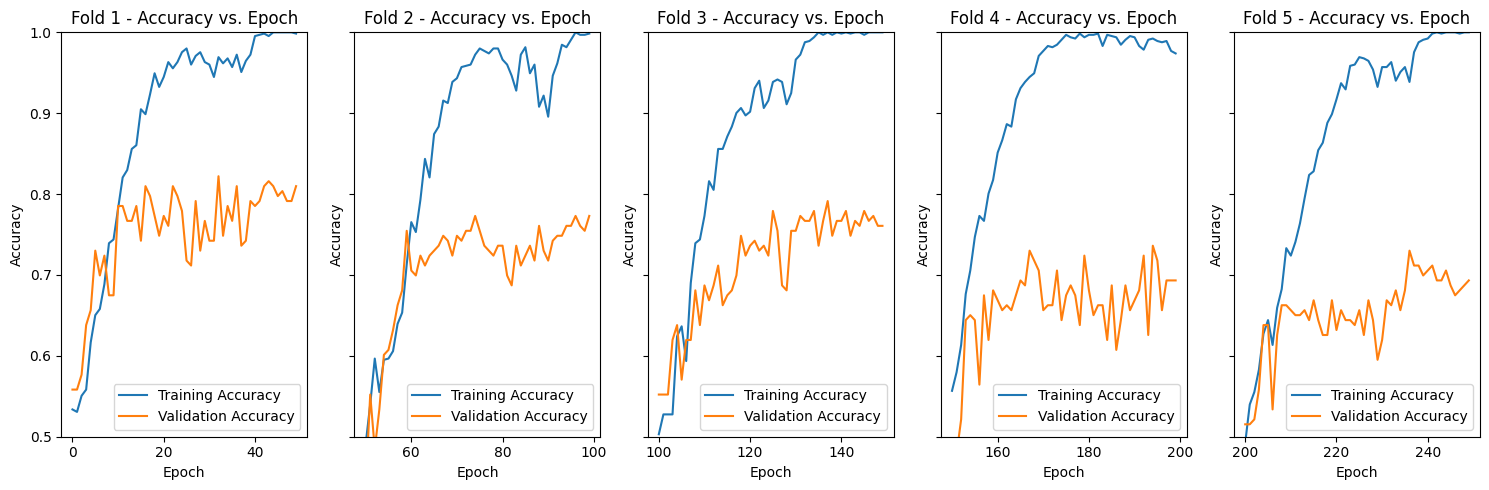

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history_df):
    num_folds = history_df['fold'].nunique()
    fig, axes = plt.subplots(1, num_folds, figsize=(15, 5), sharey=True)

    for i, fold_no in enumerate(history_df['fold'].unique()):
        fold_data = history_df[history_df['fold'] == fold_no]
        axes[i].plot(fold_data['accuracy'], label='Training Accuracy')
        axes[i].plot(fold_data['val_accuracy'], label='Validation Accuracy')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Accuracy')
        axes[i].set_ylim([0.5, 1])
        axes[i].legend(loc='lower right')
        axes[i].set_title(f'Fold {fold_no} - Accuracy vs. Epoch')

    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **One plot for each fold**

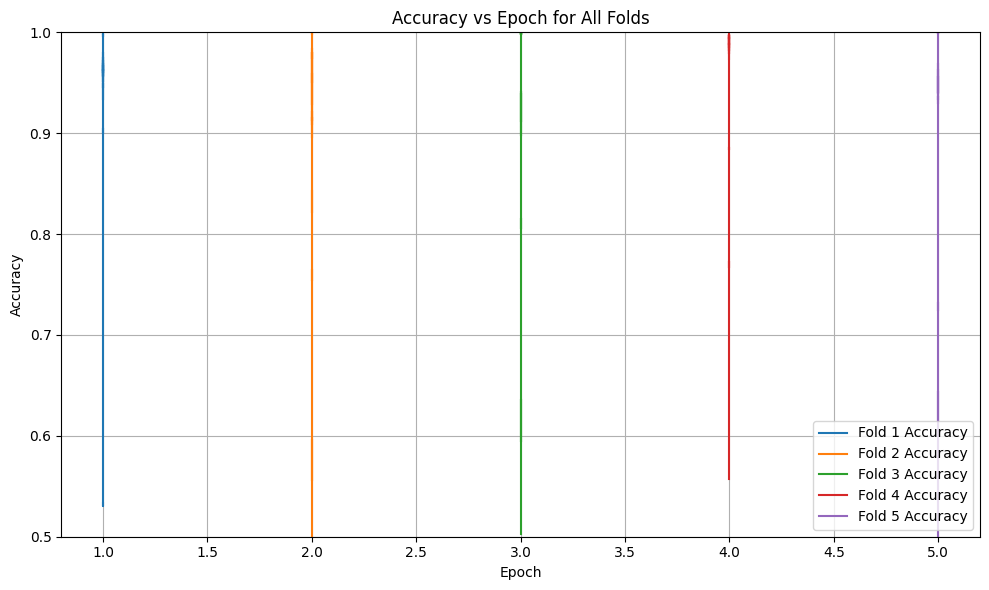

In [ ]:
def plot_accuracy(history_df):
    plt.figure(figsize=(10, 6))

    for fold_no in history_df['fold'].unique():
        fold_data = history_df[history_df['fold'] == fold_no]
        plt.plot(fold_data['fold'], fold_data['accuracy'], label=f'Fold {fold_no} Accuracy')
        # plt.plot(fold_data['fold'], fold_data['val_accuracy'], label=f'Fold {fold_no} Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Accuracy vs Epoch for All Folds')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **Average accuracy for all folds**

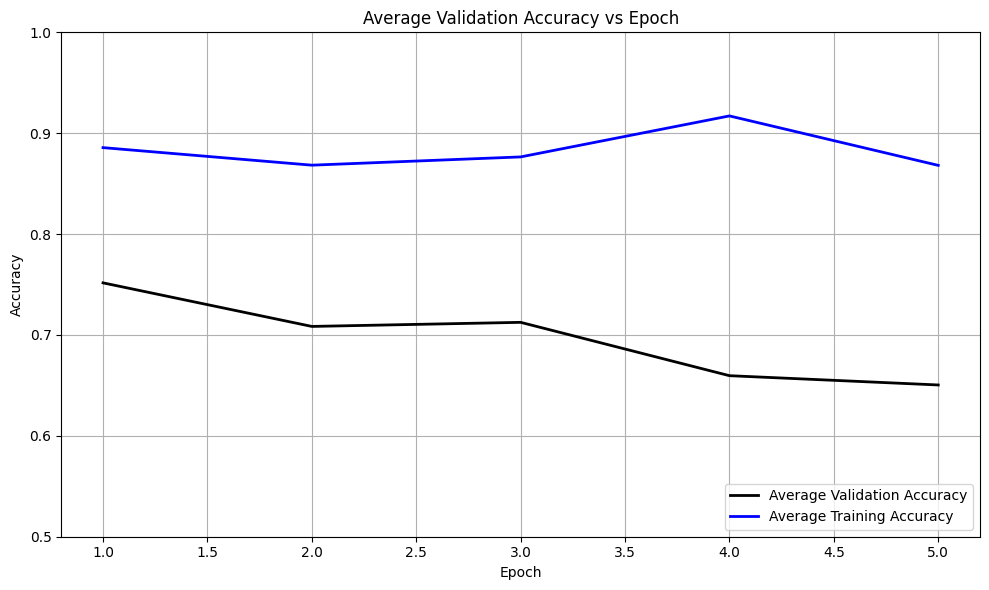

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history_df):
    plt.figure(figsize=(10, 6))
    mean_val_accuracy = history_df.groupby('fold')['val_accuracy'].mean()
    mean_accuracy = history_df.groupby('fold')['accuracy'].mean()
    plt.plot(mean_val_accuracy.index, mean_val_accuracy.values, label='Average Validation Accuracy', linewidth=2, color='black')
    plt.plot(mean_accuracy.index, mean_accuracy.values, label='Average Training Accuracy', linewidth=2, color='blue')


    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Average Validation Accuracy vs Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **Validation Loss Per Epoch**

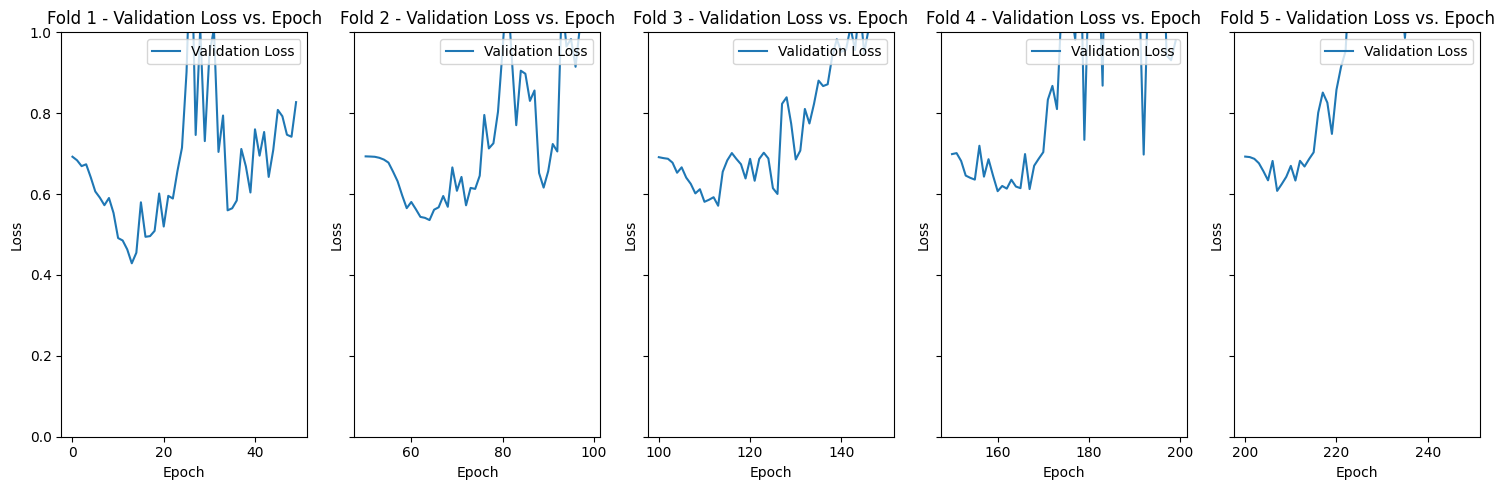

In [ ]:
def validation_loss(history_df):
    num_folds = history_df['fold'].nunique()
    fig, axes = plt.subplots(1, num_folds, figsize=(15, 5), sharey=True)
    for i, fold_no in enumerate(history_df['fold'].unique()):
        fold_data = history_df[history_df['fold'] == fold_no]
        axes[i].plot(fold_data['val_loss'], label='Validation Loss')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].set_ylim([0, 1])
        axes[i].legend(loc='upper right')
        axes[i].set_title(f'Fold {fold_no} - Validation Loss vs. Epoch')

    plt.tight_layout()
    plt.show()

validation_loss(history_df)

# **One plot each fold**

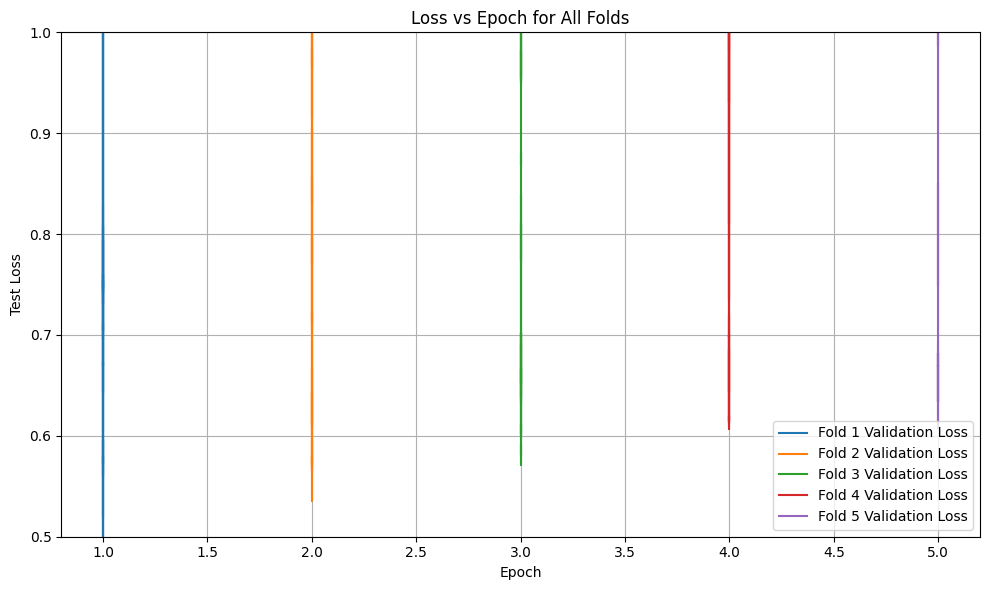

In [ ]:
def plot_accuracy(history_df):
    plt.figure(figsize=(10, 6))

    for fold_no in history_df['fold'].unique():
        fold_data = history_df[history_df['fold'] == fold_no]
        plt.plot(fold_data['fold'], fold_data['val_loss'], label=f'Fold {fold_no} Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Loss vs Epoch for All Folds')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **Average Loss for all Folds**

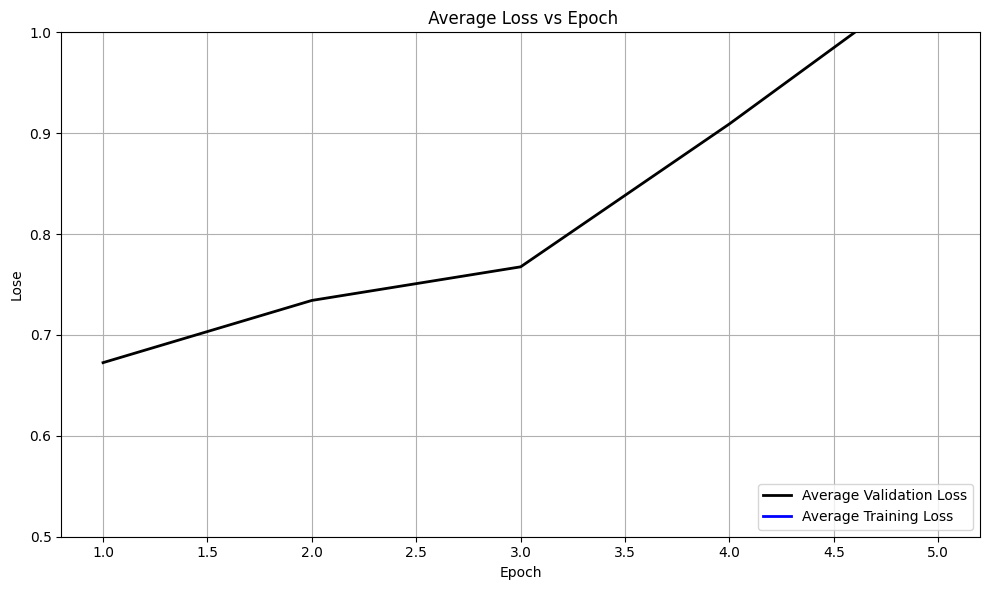

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history_df):
    plt.figure(figsize=(10, 6))
    mean_val_accuracy = history_df.groupby('fold')['val_loss'].mean()
    mean_accuracy = history_df.groupby('fold')['loss'].mean()
    plt.plot(mean_val_accuracy.index, mean_val_accuracy.values, label='Average Validation Loss', linewidth=2, color='black')
    plt.plot(mean_accuracy.index, mean_accuracy.values, label='Average Training Loss', linewidth=2, color='blue')


    plt.xlabel('Epoch')
    plt.ylabel('Lose')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title(' Average Loss vs Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **Confusion Matrix**

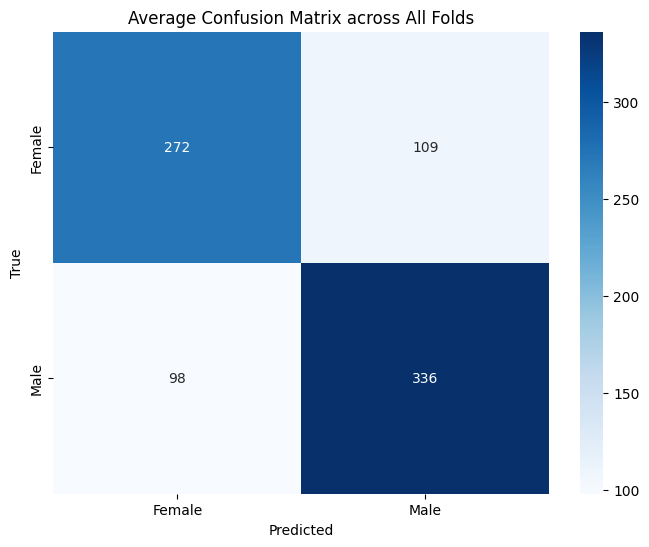

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
def plot_confusion_matrix(all_predictions, all_true_labels):
  all_predictions = np.concatenate(all_predictions)
  all_predictions = (all_predictions > 0.5).astype(int)
  all_true_labels = np.concatenate(all_true_labels)
  cm = sk_confusion_matrix(all_true_labels,all_predictions)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Average Confusion Matrix across All Folds')
  plt.show()

plot_confusion_matrix(all_predictions, all_true_labels)

# **AUC ROC Plot**

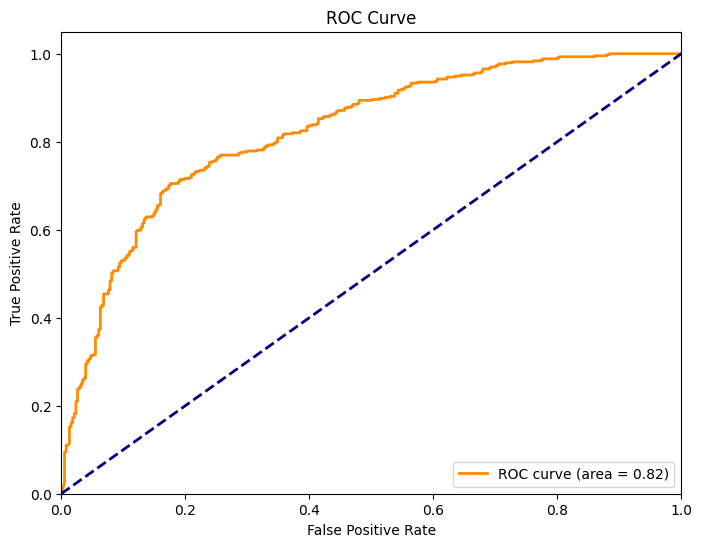

In [ ]:
def auc_roc_curve(all_predictions, all_true_labels):
    all_predictions = np.concatenate(all_predictions)
    all_true_labels = np.concatenate(all_true_labels)
    fpr, tpr, _ = roc_curve(all_true_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylim([0.0, 1.05])
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

auc_roc_curve(all_predictions, all_true_labels)

# **Ensemble Learning**

Instead of the last layer of CNN responsible for classification, will be replaced by SVM classifier. This is also known as ensemble learning which refers to algorithm that combines predictions from two or more models.

*   https://www.mdpi.com/1424-8220/22/23/9190



In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve

tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()
train_data_dir = "/content/drive/My Drive/SP 2024/Combined Augmentation/Left Lateral/"

def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=True,
        seed=42,
    )
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels).astype(np.float32)

def cnn_model(img_width=256, img_height=256):
    CNN_model = Sequential([
        layers.Input(shape=(img_width, img_height,3)),
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), padding='same'),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return CNN_model

def train_evaluate_fold(
    train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256,
    no_epochs=50,
    num_folds=5
):
    seed_and_environment()
    image_files, labels = load_dataset(train_data_dir, batch_size, img_width, img_height)
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    all_predictions = []
    all_true_labels = []
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    auc_per_fold = []
    fold_metrics = {
        'fold_no': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auc': []
    }

    for fold_no, (train_idx, test_idx) in enumerate(kfold.split(image_files, labels), 1):
        print(f'\n{"-"*80}')
        print(f'Training fold {fold_no}')

        # create datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[train_idx], labels[train_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[test_idx], labels[test_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # train CNN model
        CNN_SVM_model = cnn_model(img_width, img_height)
        CNN_SVM_model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=['accuracy'])

        CNN_SVM_model.fit(train_ds, epochs=no_epochs, validation_data=val_ds, verbose=1)

        CNN_features_train = []
        # extract CNN features for training
        for img_batch, _ in train_ds:
            CNN_features_batch = CNN_SVM_model.predict(img_batch)
            CNN_features_train.append(CNN_features_batch)
        CNN_features_train = np.concatenate(CNN_features_train)

        CNN_features_val = []
        for img_batch, _ in val_ds:
            CNN_features_batch = CNN_SVM_model.predict(img_batch)
            CNN_features_val.append(CNN_features_batch)
        CNN_features_val = np.concatenate(CNN_features_val)

        # standardize SVM classifier
        scaler = StandardScaler()
        CNN_features_train = scaler.fit_transform(CNN_features_train)
        CNN_features_val = scaler.transform(CNN_features_val)

        # train SVM classifier
        svm_model = SVC(kernel='linear', probability=True)
        svm_model.fit(CNN_features_train, labels[train_idx])

        y_pred = svm_model.predict(CNN_features_val)
        y_true = labels[test_idx]

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, svm_model.predict_proba(CNN_features_val)[:, 1])

        # store metrics
        fold_metrics['fold_no'].append(fold_no)
        fold_metrics['accuracy'].append(accuracy * 100)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1_score'].append(f1)
        fold_metrics['auc'].append(roc_auc)

        # append scores
        all_predictions.append(y_pred)
        all_true_labels.append(y_true)
        acc_per_fold.append(accuracy * 100)
        auc_per_fold.append(roc_auc)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)

    # display results
    print('\n' + '-'*80)
    print('Score per fold:')
    for i in range(len(acc_per_fold)):
        print(f'> Fold {i + 1} - Accuracy: {acc_per_fold[i]}%')
        print(f'> Fold {i + 1} - Precision: {precision_per_fold[i]}')
        print(f'> Fold {i + 1} - Recall: {recall_per_fold[i]}')
        print(f'> Fold {i + 1} - F1 score: {f1_per_fold[i]}')
        print(f'> Fold {i + 1} - AUC: {auc_per_fold[i]}')

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold):.2f}% (±{np.std(acc_per_fold):.2f})')
    print(f'Precision: {np.mean(precision_per_fold):.4f} (±{np.std(precision_per_fold):.4f})')
    print(f'Recall: {np.mean(recall_per_fold):.4f} (±{np.std(recall_per_fold):.4f})')
    print(f'F1: {np.mean(f1_per_fold):.4f} (±{np.std(f1_per_fold):.4f})')
    print(f'AUC: {np.mean(auc_per_fold):.4f} (±{np.std(auc_per_fold):.4f})')

    return CNN_SVM_model, fold_metrics

CNN_SVM_model, fold_metrics = train_evaluate_fold(train_data_dir)

# model summary
CNN_SVM_model.summary()

Found 815 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



--------------------------------------------------------------------------------
Training fold 1
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.5100 - loss: 0.8449 - val_accuracy: 0.5583 - val_loss: 0.6924
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.5226 - loss: 0.6923 - val_accuracy: 0.5583 - val_loss: 0.6836
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.5321 - loss: 0.6867 - val_accuracy: 0.5767 - val_loss: 0.6692
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.5424 - loss: 0.6839 - val_accuracy: 0.6380 - val_loss: 0.6737
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5977 - loss: 0.6667 - val_accuracy: 0.6564 - val_loss: 0.6418
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.6566 - loss: 0.6370 - val_accuracy: 0.7301 - val_loss: 0.6065
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.6746 - loss: 0.6147 - val_accuracy: 0.6994 - val_loss: 0.5912
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.6965 - loss: 0.5809 - val_accuracy: 0.7239 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step - accuracy: 0.5030 - loss: 1.1341 - val_accuracy: 0.4356 - val_loss: 0.6933
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5417 - loss: 0.6930 - val_accuracy: 0.5521 - val_loss: 0.6929
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.5893 - loss: 0.6921 - val_accuracy: 0.4847 - val_loss: 0.6922
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5208 - loss: 0.6922 - val_accuracy: 0.5337 - val_loss: 0.6897
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5918 - loss: 0.6816 - val_accuracy: 0.6012 - val_loss: 0.6853
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.6089 - loss: 0.6827 - val_accuracy: 0.6074 - val_loss: 0.6778
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.6141 - loss: 0.6689 - val_accuracy: 0.6319 - val_loss: 0.6556
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.6426 - loss: 0.6375 - val_accuracy: 0.6626 - val_

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

--------------------------------------------------------------------------------
Training fold 3
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.4941 - loss: 0.9443 - val_accuracy: 0.5521 - val_loss: 0.6913
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.5195 - loss: 0.6933 - val_accuracy: 0.5521 - val_loss: 0.6890
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.5195 - loss: 0.6920 - val_accuracy: 0.5521 - val_loss: 0.6873
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.5229 - loss: 0.6849 - val_accuracy: 0.6196 - val_loss: 0.6777
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.6216 - loss: 0.6704 - val_accuracy: 0.6380 - val_loss: 0.6528
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.6612 - loss: 0.6480 - val_accuracy: 0.5706 - val_loss: 0.6662
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5643 - loss: 0.6616 - val_accuracy: 0.6196 - val_loss: 0.6407
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.6931 - loss: 0.6036 - val_accuracy: 0.6196 - val_

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

--------------------------------------------------------------------------------
Training fold 4
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.5753 - loss: 1.1426 - val_accuracy: 0.4724 - val_loss: 0.6989
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.5537 - loss: 0.6878 - val_accuracy: 0.4785 - val_loss: 0.7013
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.5986 - loss: 0.6623 - val_accuracy: 0.5215 - val_loss: 0.6818
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.6754 - loss: 0.6155 - val_accuracy: 0.6442 - val_loss: 0.6458
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.7223 - loss: 0.5568 - val_accuracy: 0.6503 - val_loss: 0.6402
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.7524 - loss: 0.5301 - val_accuracy: 0.6442 - val_loss: 0.6358
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.7652 - loss: 0.5081 - val_accuracy: 0.5644 - val_loss: 0.7195
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.7607 - loss: 0.4848 - val_accuracy: 0.6748 - val_

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

--------------------------------------------------------------------------------
Training fold 5
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.4874 - loss: 1.7878 - val_accuracy: 0.5153 - val_loss: 0.6927
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5138 - loss: 0.6930 - val_accuracy: 0.5153 - val_loss: 0.6915
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.5180 - loss: 0.6912 - val_accuracy: 0.5215 - val_loss: 0.6872
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5717 - loss: 0.6857 - val_accuracy: 0.5583 - val_loss: 0.6764
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.6052 - loss: 0.6796 - val_accuracy: 0.6380 - val_loss: 0.6563
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.6395 - loss: 0.6561 - val_accuracy: 0.6380 - val_loss: 0.6340
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.6285 - loss: 0.6332 - val_accuracy: 0.5337 - val_loss: 0.6820
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.6118 - loss: 0.6525 - val_accuracy: 0.6258 - val_

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

--------------------------------------------------------------------------------
Score per fold:
> Fold 1 - Accuracy: 80.98159509202453%
> Fold 1 - Precision: 0.8
> Fold 1 - Recall: 0.8791208791208791
> Fold 1 - F1 score: 0.837696335078534
> Fold 1 - AUC: 0.8746947496947497
> Fold 2 - Accuracy: 76.68711656441718%
> Fold 2 - Precision: 0.84615384615384

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_38 (Rescaling)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ (None, 86, 86, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 86, 86, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_38 (Flatten)                 │ (None, 26912)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 128)                 │       3,444,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,395,749 (39.66 MB)

 Trainable params: 3,465,249 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,930,500 (26.44 MB)

# CNN and SVM as Feature Extractor

use a CNN to extract features from the image, then store these features in a CSV file, where each row represents an image and each column represents a feature.

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

# Enable eager execution
tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()

train_data_dir = "/content/drive/My Drive/SP 2024/Combined Augmentation/Left Lateral/"

# Set seed for reproducibility
def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

# Load dataset
def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=True,
        seed=42,
    )
    return dataset

# Create CNN model
def create_cnn_model(img_width=256, img_height=256):
    inputs = Input(shape=(img_width, img_height, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Extract and save CNN features to CSV
def extract_save_features(model, train_data_dir, batch_size, img_width, img_height):
    seed_and_environment()

    # Load dataset
    dataset = load_dataset(train_data_dir, batch_size, img_width, img_height)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=binary_crossentropy,
                  metrics=['accuracy'])

    model.build(input_shape=(None, img_width, img_height, 3))

    # Train the CNN model
    model.fit(dataset, epochs=2, verbose=1)

    # Create feature extractor (take output from second-to-last layer)
    feature_extractor = Model(inputs=model.input,
                              outputs=model.layers[-2].output)

    all_features = []
    all_labels = []

    for images, labels in dataset:
        features = feature_extractor.predict(images)
        all_features.append(features)
        all_labels.append(labels)

    CNN_features = np.concatenate(all_features, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    # Name each feature column as feature_1, feature_2, ..., feature_128
    feature_column_names = [f"feature_{i+1}" for i in range(CNN_features.shape[1])]
    features_df = pd.DataFrame(CNN_features, columns=feature_column_names)

    # Add label column
    labels_df = pd.DataFrame(labels, columns=["label"])
    features_df = pd.concat([features_df, labels_df], axis=1)

    # Save to CSV
    features_df.to_csv('CNN_features.csv', index=False)
    print("Saved CNN features to 'CNN_features.csv'")

    return features_df

# Create model instance
model = create_cnn_model(img_width=256, img_height=256)

# Run feature extraction and save to CSV
features_df = extract_save_features(
    model=model,
    train_data_dir=train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256
)

Found 815 files belonging to 2 classes.
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - accuracy: 0.5171 - loss: 1.4553
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - accuracy: 0.5170 - loss: 0.6926
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Saved CNN features to 'CNN_features.csv'


In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Load the dataset
df = pd.read_csv('CNN_features.csv')
X = df.drop('label', axis=1)
y = df['label']

# Define the models and their hyperparameter grids
models_and_grids = {
    'Logistic Regression': (LogisticRegression(), {'C': [0.01, 0.1, 1, 10]}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}),
    'Support Vector Machine': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}),
    'Extra Trees': (ExtraTreesClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]})
}

# Initialize an empty list to store the results
model_scores = []

# Loop through each model, perform grid search, and capture fold-wise CV scores
for model_name, (model, param_grid) in models_and_grids.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=False)
    grid_search.fit(X, y)

    # Get the best estimator's CV results
    best_index = grid_search.best_index_

    # Get fold scores for the best parameters only
    fold_scores = [
        grid_search.cv_results_['split0_test_score'][best_index],
        grid_search.cv_results_['split1_test_score'][best_index],
        grid_search.cv_results_['split2_test_score'][best_index],
        grid_search.cv_results_['split3_test_score'][best_index],
        grid_search.cv_results_['split4_test_score'][best_index]
    ]

    # Calculate the average score across folds
    avg_score = sum(fold_scores) / len(fold_scores)

    # Convert to percentage by multiplying by 100 for display
    fold_scores_percentage = [score * 100 for score in fold_scores]
    avg_score_percentage = avg_score * 100

    # Round each fold score individually
    fold_scores_rounded = [round(score, 2) for score in fold_scores_percentage]

    # Round the average score
    avg_score_rounded = round(avg_score_percentage, 2)

    # Append the fold scores and average score to the list
    model_scores.append({
        'Model': model_name,
        'Fold 1': fold_scores_rounded[0],
        'Fold 2': fold_scores_rounded[1],
        'Fold 3': fold_scores_rounded[2],
        'Fold 4': fold_scores_rounded[3],
        'Fold 5': fold_scores_rounded[4],
        'Average CV Score': avg_score_rounded,
        'Best Parameters': grid_search.best_params_
    })

# Create a DataFrame to display the results
scores_df = pd.DataFrame(model_scores)

# Display the table sorted by average score in descending order
scores_df = scores_df.sort_values(by='Average CV Score', ascending=False).reset_index(drop=True)

# Display the table
print("Model Comparison Based on Cross-Validation Scores (Fold-wise and Average)")
scores_df[['Model', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Average CV Score', 'Best Parameters']]

Training Logistic Regression...
Training K-Nearest Neighbors...
Training Support Vector Machine...
Training Random Forest...
Training AdaBoost...
Training Extra Trees...
Training Gradient Boosting...
Model Comparison Based on Cross-Validation Scores (Fold-wise and Average)


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average CV Score,Best Parameters
0,Extra Trees,76.07,70.55,71.78,74.23,73.01,73.13,"{'max_depth': None, 'n_estimators': 100}"
1,Gradient Boosting,75.46,73.62,72.39,73.01,66.26,72.15,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
2,Random Forest,76.69,69.33,71.78,72.39,69.94,72.02,"{'max_depth': None, 'n_estimators': 200}"
3,K-Nearest Neighbors,74.85,66.87,74.23,69.94,67.48,70.67,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei..."
4,Support Vector Machine,73.01,67.48,67.48,74.23,70.55,70.55,"{'C': 10, 'kernel': 'rbf'}"
5,Logistic Regression,71.78,66.87,66.26,72.39,72.39,69.94,{'C': 10}
6,AdaBoost,74.85,69.94,67.48,66.26,69.94,69.69,"{'learning_rate': 1, 'n_estimators': 100}"


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Define custom scoring for precision, recall, and F1
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Initialize a list to store average metrics
average_metrics = []

# Loop again to use the best models from the previous grid searches
for model_data in model_scores:
    model_name = model_data['Model']
    best_params = model_data['Best Parameters']

    # Recreate the model with best parameters
    base_model, _ = models_and_grids[model_name]
    best_model = base_model.set_params(**best_params)

    # Perform cross-validation with precision, recall, f1
    cv_results = cross_validate(best_model, X, y, cv=5, scoring=scoring)

    avg_precision = round(cv_results['test_precision'].mean() * 100, 2)
    avg_recall = round(cv_results['test_recall'].mean() * 100, 2)
    avg_f1 = round(cv_results['test_f1'].mean() * 100, 2)

    average_metrics.append({
        'Model': model_name,
        'Avg Precision': avg_precision,
        'Avg Recall': avg_recall,
        'Avg F1 Score': avg_f1
    })

# Create a DataFrame for average metrics
metrics_df = pd.DataFrame(average_metrics)

# Sort by F1 Score for easy comparison
metrics_df = metrics_df.sort_values(by='Avg F1 Score', ascending=False).reset_index(drop=True)

# Display the second table
print("\nModel Comparison Based on Average Precision, Recall, and F1-Score (5-Fold CV)")
metrics_df


Model Comparison Based on Average Precision, Recall, and F1-Score (5-Fold CV)


,Model,Avg Precision,Avg Recall,Avg F1 Score
0,Random Forest,73.19,73.13,72.96
1,Extra Trees,71.60,71.53,71.31
2,Gradient Boosting,71.31,71.29,71.16
3,K-Nearest Neighbors,70.97,70.67,70.29
4,Support Vector Machine,71.00,70.55,70.03
5,AdaBoost,69.77,69.69,69.47
6,Logistic Regression,70.32,69.94,69.43


#**Visualizing the Dataset**

In [ ]:
def plot_confusion_matrix(model, X, y, model_name):
    """
    Generates and plots a confusion matrix.

    Args:
        model: The trained model.
        X: The input features.
        y: The true labels.
        model_name: The name of the model (for the plot title).
    """
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# ... (your existing code for training models and finding the best one) ...

# Now, call the function to plot the confusion matrix for the best model:
plot_confusion_matrix(best_model, X, y, best_model_name)

NameError: name 'best_model_name' is not defined